In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import interpolate
from scipy.signal import find_peaks
import os

In [2]:
def read_s2p_file(file_path):
    """
    Reads a .s2p file and processes it into a pandas DataFrame.

    Parameters:
        file_path (str): The path to the .s2p file to be read.

    Returns:
        pandas.DataFrame: A DataFrame containing the data from the .s2p file with columns for frequency and S-parameters.
    """
    # Open the file and read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Skip lines that start with '#' or '!' (typically headers or comments in .s2p files)
    data = [line.strip().split() for line in lines if not (line.startswith('#') or line.startswith('!'))]
    
    # Convert the processed data into a DataFrame with appropriate column names
    df = pd.DataFrame(data, columns=[
        'Frequency (Hz)', 'S11 (dB)', 'S11 (Angle)', 
        'S21 (dB)', 'S21 (Angle)', 'S12 (dB)', 
        'S12 (Angle)', 'S22 (dB)', 'S22 (Angle)'
    ])
    
    # Convert all columns to numeric values (since the file data is in string format initially)
    df = df.apply(pd.to_numeric)
    
    # Return the DataFrame containing the processed data
    return df


In [3]:
# Directories for all datasets
directories = {
    "Citi1_P12_PreAmp": r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-10-29/Citi1-P12-PreAmp',
    "Citi1_P23_PreAmp": r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-11-08/Citi1-P23-PreAmp',
    "Citi2_P7_PreAmp": r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-11-08/Citi2-P7-PreAmp',
    "Citi2_P28_PreAmp": r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-11-08/Citi2-P28-PreAmp',
    "Citi1_P12_PreAmp_Puerto_Calib": r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-11-08/Citi1-P12-PreAmp_Puerto_Calib',
    "Citi1_P12_FastShaper": r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-12-03/Citi1-P12-FS',
    "Citi1_P23_FastShaper": r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-12-03/Citi1-P23-FS',
    "Citi2_P7_FastShaper": r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-12-03/Citi2-P7-FS',
    "Citi2_P28_FastShaper": r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-12-03/Citi2-P28-FS'
}

# Define specific gain ranges for each directory
gain_ranges = {
    "Citi1_P12_PreAmp": range(64),
    "Citi1_P23_PreAmp": range(64),
    "Citi2_P7_PreAmp": range(64),
    "Citi2_P28_PreAmp": range(64),
    "Citi1_P12_PreAmp_Puerto_Calib": range(0, 64, 2),  # Only even gains
    "Citi1_P12_FastShaper": [0, 15, 31, 47, 63],  # Specific gains
    "Citi1_P23_FastShaper": [0, 15, 31, 47, 63],
    "Citi2_P7_FastShaper": [0, 15, 31, 47, 63],
    "Citi2_P28_FastShaper": [0, 15, 31, 47, 63]
}

# Dictionary to hold data for all directories
data = {key: {} for key in directories.keys()}

# Load all .s2p files for each directory
for key, directory in directories.items():
    for gain in gain_ranges[key]:
        # Construct the file path for the current gain index
        file_path = os.path.join(directory, f'ganancia_{gain}.s2p')
        
        # Check if the file exists before attempting to read it
        if os.path.exists(file_path):
            data[key][gain] = read_s2p_file(file_path)
        else:
            print(f"Warning: File not found - {file_path}")

Aca agrego la *Calibracion* hecha con el Citi2_P7_PreAmp.

La idea de esto es tener una nocion de cuanto es la variacion estadistica que hay de medicion a medicion cuando se repiten las mediciones a igual ganancia.

Highest Standard Deviation (S21) below 30000000.0 Hz: 0.06121686150392559 dB


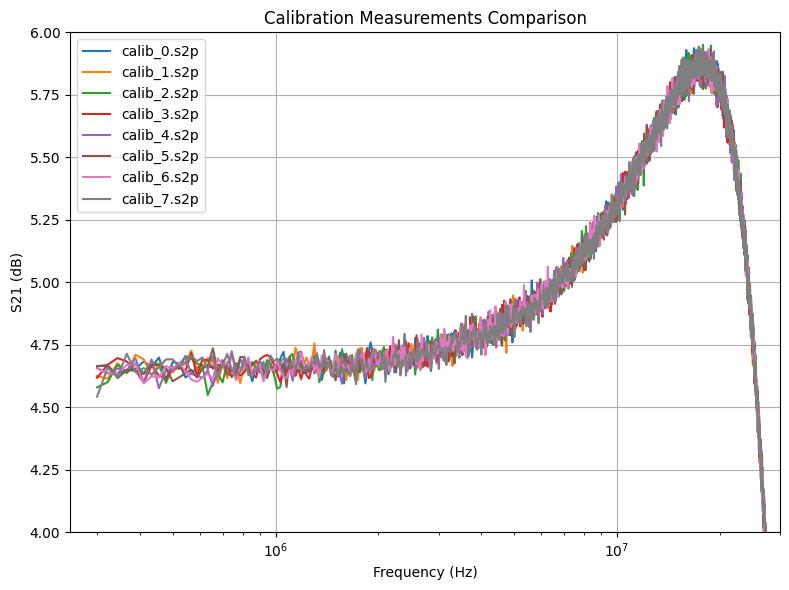

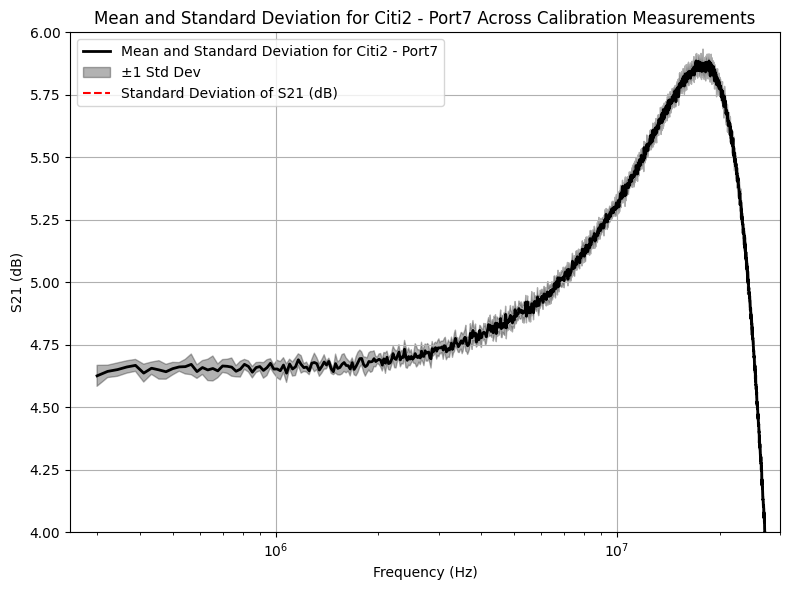

In [4]:
# Read the calibration files only once
calibration_dir = '/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones CITI VNA/2024-11-08/Calibracion - C2-P7-PA'
calib_files = [f'calib_{i}.s2p' for i in range(8)]  # calib_0 to calib_7
calib_data = {}

# Read all calibration files into a dictionary
for calib_file in calib_files:
    file_path = os.path.join(calibration_dir, calib_file)
    calib_data[calib_file] = read_s2p_file(file_path)

# Now proceed with the mean and standard deviation calculation, using the already loaded data
frequencies = calib_data['calib_0.s2p']['Frequency (Hz)']  # All files have the same frequency range
mean_s21 = np.mean([df['S21 (dB)'] for df in calib_data.values()], axis=0)
std_s21 = np.std([df['S21 (dB)'] for df in calib_data.values()], axis=0)

# Find the indices of the frequencies below the cutoff
frequency_cutoff = 3e7
below_cutoff_indices = frequencies <= frequency_cutoff

# Extract the standard deviation values before the cutoff
std_s21_below_cutoff = std_s21[below_cutoff_indices]

# Find the maximum standard deviation before the cutoff
max_std_below_cutoff = np.max(std_s21_below_cutoff)

# Print the highest standard deviation below the cutoff
print(f"Highest Standard Deviation (S21) below {frequency_cutoff} Hz: {max_std_below_cutoff} dB")


# Plot the calibration measurements and their mean (using the already loaded data)
plt.figure(figsize=(8, 6))
for calib_file in calib_files:  # Iterate over string keys directly
    plt.plot(calib_data[calib_file]['Frequency (Hz)'], calib_data[calib_file]['S21 (dB)'], label=f'{calib_file}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('S21 (dB)')
plt.ylim(4, 6)
plt.xlim(2.5e5, 3e7)
plt.xscale('log')
plt.title('Calibration Measurements Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('datos_calibracion.pdf', dpi=1000)
plt.show()

# Plot the Mean and Standard Deviation S21 (dB) in a separate plot
plt.figure(figsize=(8, 6))
plt.plot(frequencies, mean_s21, label='Mean and Standard Deviation for Citi2 - Port7', color='black', linewidth=2)
plt.fill_between(frequencies, mean_s21 - std_s21, mean_s21 + std_s21, alpha=0.3, color='black', label='±1 Std Dev')
plt.plot(frequencies, std_s21, label='Standard Deviation of S21 (dB)', color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('S21 (dB)')
plt.xscale('log')
plt.ylim(4, 6)
plt.xlim(2.5e5, 3e7)
plt.title('Mean and Standard Deviation for Citi2 - Port7 Across Calibration Measurements')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('calibracion_analisis.pdf', dpi=1000)
plt.show()

Voy a poner algunas de las funciones que voy a ir usando muchas veces aca arriba:

- Funcion que me plotea los datos crudos que separa pares de impares
- Clase para todo el analisis de residuos:
  * Plotear todos los residuos de todas la ganancias
  * Plotear un mapa de calor para ver cuales son las ganancias mas diferentes rapido
  * Ver el valor medio y STD de todos los residuos
  * Lo mismo arriba del cuttoff que pongo donde empieza a haber mucho ruido

In [5]:
def plot_even_odd_gains(data, dataset_1, dataset_2, plot_even_only=False):
    """
    Plots even and odd gain indices separately, including dataset names in the title.
    
    Parameters:
        data (dict): Preloaded dictionary containing gain data for each dataset.
        dataset_1 (str): Key for the first dataset in the data dictionary.
        dataset_2 (str): Key for the second dataset in the data dictionary.
        plot_even_only (bool): If True, only even gain indices will be plotted. Default is False.
    """
    linestyle_map = {dataset_1: '-', dataset_2: '--'}
    
    # Define ranges for even and odd indices
    if plot_even_only:
        ranges = {'Even Gains': range(0, 64, 2)}  # Only even indices
    else:
        ranges = {'Even Gains': range(0, 64, 2), 'Odd Gains': range(1, 64, 2)}  # Both even and odd
    
    for gain_type, indices in ranges.items():
        plt.figure(figsize=(12, 8))
        
        for i in indices:
            df_1 = data[dataset_1][i]
            df_2 = data[dataset_2][i]
            
            # Plot for each gain index
            plt.plot(df_1['Frequency (Hz)'], df_1['S21 (dB)'], 
                     label=f'{dataset_1} Gain {i}', linestyle=linestyle_map[dataset_1])
            plt.plot(df_2['Frequency (Hz)'], df_2['S21 (dB)'], 
                     label=f'{dataset_2} Gain {i}', linestyle=linestyle_map[dataset_2])
        
        # Customize plot
        plt.xlabel('Frequency (Hz)')
        plt.ylim(4, 41)
        plt.xscale('log')
        plt.ylabel('S21 (dB)')
        plt.xlim(2.5e5, 3e7)
        plt.title(f'S21 (dB) Comparison: {dataset_1} vs {dataset_2} - {gain_type}')
        plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), ncol=2, fontsize='small')
        plt.tight_layout()
        plt.grid()
        plt.show()


In [6]:
class ResidualAnalysis:
    def __init__(self, data, dataset_1_key, dataset_2_key, max_std, frequency_cutoff=5e7, exclude_gains=None, even_gains_only=False):
        """
        Initializes the ResidualAnalysis class with the selected datasets, calibration data, frequency cutoff, and optional gain exclusions.

        Parameters:
            data (dict): Dictionary containing gain data for each dataset.
            dataset_1_key (str): The key for the first dataset (e.g., 'Citi1_P12_PreAmp').
            dataset_2_key (str): The key for the second dataset (e.g., 'Citi1_P12_PreAmp_Puerto_Calib').
            calibration_data (dict): Dictionary containing calibration residuals for each gain (e.g., 'calib_0' to 'calib_7').
            frequency_cutoff (float): Frequency cutoff value in Hz (default is 50 MHz).
            exclude_gains (list): List of gain indices to exclude (default is None, meaning no exclusion).
            even_gains_only (bool): If True, only compares even gains.
        """
        self.data = data
        self.dataset_1_key = dataset_1_key
        self.dataset_2_key = dataset_2_key
        self.max_std = max_std
        self.frequency_cutoff = frequency_cutoff
        self.exclude_gains = exclude_gains if exclude_gains is not None else []
        self.even_gains_only = even_gains_only
        self.residuals_below_cutoff = []
        self.residuals_above_cutoff = []
        self.frequencies_below_cutoff = []
        self.frequencies_above_cutoff = []

    def get_valid_gains(self):
        """Returns the valid gain indices, considering exclusions and whether to select even gains only."""
        if self.even_gains_only:
            return [i for i in range(64) if i % 2 == 0 and i not in self.exclude_gains]
        return [i for i in range(64) if i not in self.exclude_gains]

    def calculate_residuals_below_cutoff(self):
        """
        Calculates the residuals below the frequency cutoff, excluding outlier gains, and stores them.
        """
        valid_gains = self.get_valid_gains()
        
        for i in valid_gains:
            df_citi1_p12_preamp = self.data[self.dataset_1_key][i]
            df_citi1_p12_puerto_calib = self.data[self.dataset_2_key][i]
            
            # Filter data below the frequency cutoff
            df_below_cutoff_p12 = df_citi1_p12_preamp[df_citi1_p12_preamp['Frequency (Hz)'] <= self.frequency_cutoff]
            df_below_cutoff_puerto = df_citi1_p12_puerto_calib[df_citi1_p12_puerto_calib['Frequency (Hz)'] <= self.frequency_cutoff]
            
            # Calculate residuals
            self.residuals_below_cutoff.append(df_below_cutoff_p12['S21 (dB)'].values - df_below_cutoff_puerto['S21 (dB)'].values)
            if i == valid_gains[0]:
                self.frequencies_below_cutoff = df_below_cutoff_p12['Frequency (Hz)'].values
        
        self.residuals_below_cutoff = np.array(self.residuals_below_cutoff)
    
    def calculate_residuals_above_cutoff(self):
        """
        Calculates the residuals above the frequency cutoff, excluding outlier gains, and stores them.
        """
        valid_gains = self.get_valid_gains()
        
        for i in valid_gains:
            df_above_cutoff_p12 = self.data[self.dataset_1_key][i][self.data[self.dataset_1_key][i]['Frequency (Hz)'] > self.frequency_cutoff]
            df_above_cutoff_puerto = self.data[self.dataset_2_key][i][self.data[self.dataset_2_key][i]['Frequency (Hz)'] > self.frequency_cutoff]
            
            # Calculate residuals for frequencies above the cutoff
            self.residuals_above_cutoff.append(df_above_cutoff_p12['S21 (dB)'].values - df_above_cutoff_puerto['S21 (dB)'].values)
            if i == valid_gains[0]:
                self.frequencies_above_cutoff = df_above_cutoff_p12['Frequency (Hz)'].values
        
        self.residuals_above_cutoff = np.array(self.residuals_above_cutoff)

    
    def plot_heatmap_below_cutoff(self):
        """
        Generates and plots a heatmap for residuals below the frequency cutoff.
        """
        plt.figure(figsize=(14, 8))
        selected_freq_indices = np.linspace(0, len(self.frequencies_below_cutoff) - 1, num=10, dtype=int)
        selected_freq_labels = [f'{self.frequencies_below_cutoff[i]:.2e}' for i in selected_freq_indices]
        
        # Adjust for excluded gains (skip indices)
        valid_residuals = [residuals for i, residuals in enumerate(self.residuals_below_cutoff) if i not in self.exclude_gains]
        
        sns.heatmap(valid_residuals, cmap="coolwarm", xticklabels=selected_freq_indices, yticklabels=[i for i in range(64) if i not in self.exclude_gains])
        plt.xlabel('Frequency (Hz)')
        plt.xticks(ticks=selected_freq_indices, labels=selected_freq_labels, rotation=45)
        plt.ylabel('Gain Index')
        plt.title(f'Residuals Heatmap (S21 {self.dataset_1_key} - {self.dataset_2_key}) Below {self.frequency_cutoff/1e6} MHz')
        plt.show()

    def plot_mean_and_std_above_cutoff(self):
        """
        Generates and plots the mean and standard deviation of residuals above the frequency cutoff.
        """
        mean_residuals_above_cutoff = np.mean(self.residuals_above_cutoff, axis=0)
        std_residuals_above_cutoff = np.std(self.residuals_above_cutoff, axis=0)
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.frequencies_above_cutoff, mean_residuals_above_cutoff, label='Mean Residual (Smoothed)')
        plt.fill_between(self.frequencies_above_cutoff, mean_residuals_above_cutoff - std_residuals_above_cutoff,
                         mean_residuals_above_cutoff + std_residuals_above_cutoff, alpha=0.2, label='±1 Std Dev (Smoothed)')
        plt.xscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Residual (dB)')
        plt.title(f'Mean and Standard Deviation of Residuals Above {self.frequency_cutoff/1e6} MHz')
        plt.legend()
        plt.grid()
        plt.show()
    
    def plot_mean_and_std_below_cutoff(self):
        """
        Generates and plots the mean and standard deviation of residuals below the frequency cutoff.
        Adds horizontal lines at 2 * max_std_below_cutoff and -2 * max_std_below_cutoff, and shades the area between them.
        """
        mean_residuals_below_cutoff = np.mean(self.residuals_below_cutoff, axis=0)
        std_residuals_below_cutoff = np.std(self.residuals_below_cutoff, axis=0)
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.frequencies_below_cutoff, mean_residuals_below_cutoff, label='Mean Residual')
        plt.fill_between(self.frequencies_below_cutoff, mean_residuals_below_cutoff - std_residuals_below_cutoff,
                             mean_residuals_below_cutoff + std_residuals_below_cutoff, alpha=0.2, label='±1 Std Dev')
        
        # Add horizontal lines at 2 * max_std and -2 * max_std
        plt.axhline(y=2 * self.max_std, color='green', linestyle='--', label='2 * max_std_below_cutoff')
        plt.axhline(y=-2 * self.max_std, color='red', linestyle='--', label='-2 * max_std_below_cutoff')
        
        # Fill the area between the two horizontal lines with a faded color
        plt.fill_between(self.frequencies_below_cutoff, 2 * self.max_std, -2 * self.max_std, color='grey', alpha=0.2)
    
        plt.xscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Residual (dB)')
        plt.title(f'Mean and Standard Deviation of Residuals Below {self.frequency_cutoff/1e6} MHz')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_residuals(self):
        """
        Plots the residuals (S21 difference) for all gain indices in separate subplots, excluding gains with outliers.
        Adds horizontal lines at 2 * max_std_below_cutoff and -2 * max_std_below_cutoff, and shades the area between them.
        """
        # Create a subplot grid (16x4)
        fig, axes = plt.subplots(16, 4, figsize=(20, 40), sharex=True, sharey=True)
        axes = axes.flatten()
    
        # Loop through all gain indices
        valid_gain_indices = [i for i in range(64) if i not in self.exclude_gains]
    
        for i, valid_index in enumerate(valid_gain_indices):
            # Access the data for the current gain index
            df_1 = self.data[self.dataset_1_key][valid_index]
            df_2 = self.data[self.dataset_2_key][valid_index]
        
            # Calculate the residuals (difference between the two datasets' S21 values)
            residuals = df_1['S21 (dB)'] - df_2['S21 (dB)']
        
            # Plot residuals for each gain index
            axes[i].plot(df_1['Frequency (Hz)'], residuals, label=f'Residual Gain {valid_index}')
            axes[i].set_xscale('log')
            axes[i].grid()
            axes[i].set_xlim(3e5, 3e7)
            axes[i].set_ylim(-0.9, 0.9)
            axes[i].set_title(f'Residuals for Gain {valid_index}')
        
            # Add horizontal lines at 2 * max_std and -2 * max_std
            axes[i].axhline(y=2 * self.max_std, color='green', linestyle='--', label='2 * max_std_below_cutoff')
            axes[i].axhline(y=-2 * self.max_std, color='red', linestyle='--', label='-2 * max_std_below_cutoff')
        
            # Shade the area between the two horizontal lines
            axes[i].fill_between(df_1['Frequency (Hz)'], 2 * self.max_std, -2 * self.max_std, color='grey', alpha=0.2)

            # Label y-axis on the leftmost plots
            if i % 4 == 0:
                axes[i].set_ylabel('Residual (dB)')
            
            # Label x-axis on the bottom plots
            if i >= len(valid_gain_indices) - 4:  # Modify to ensure x-axis labels appear only at the bottom
                axes[i].set_xlabel('Frequency (Hz)')
    
        # Add an overall title and adjust the layout
        fig.suptitle(f'Residuals of S21 (dB) Difference: {self.dataset_1_key} - {self.dataset_2_key}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to avoid overlap
        plt.show()


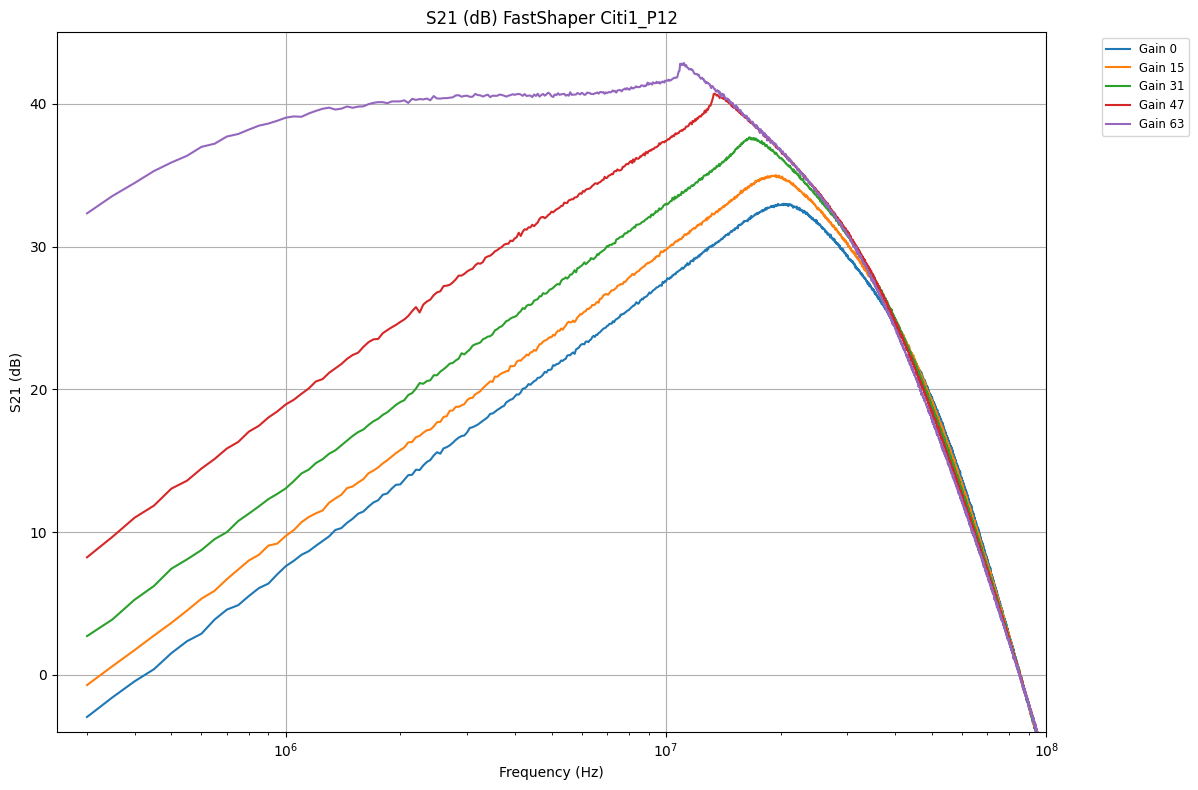

In [9]:
plt.figure(figsize=(12, 8))

# Gains available in the FastShaper dataset
fastshaper_gains = [0, 15, 31, 47, 63]

# Loop through the preloaded data for FastShaper
for i in fastshaper_gains:
    df_fastshaper = data['Citi1_P12_FastShaper'][i]  # Replace with the actual dataset key
    
    # Plot S21 (dB) vs Frequency (Hz)
    plt.plot(df_fastshaper['Frequency (Hz)'], df_fastshaper['S21 (dB)'], label=f'Gain {i}')

# Customize the plot
plt.xlabel('Frequency (Hz)')
plt.ylim(-4, 45)  # Adjust the range if necessary based on your FastShaper data
plt.xscale('log')
plt.ylabel('S21 (dB)')
plt.xlim(2.5e5, 1e8)
plt.title('S21 (dB) FastShaper Citi1_P12')  # Update title for clarity
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.grid(True)
plt.savefig('datos_crudos_fs.pdf', dpi=1000)
plt.show()


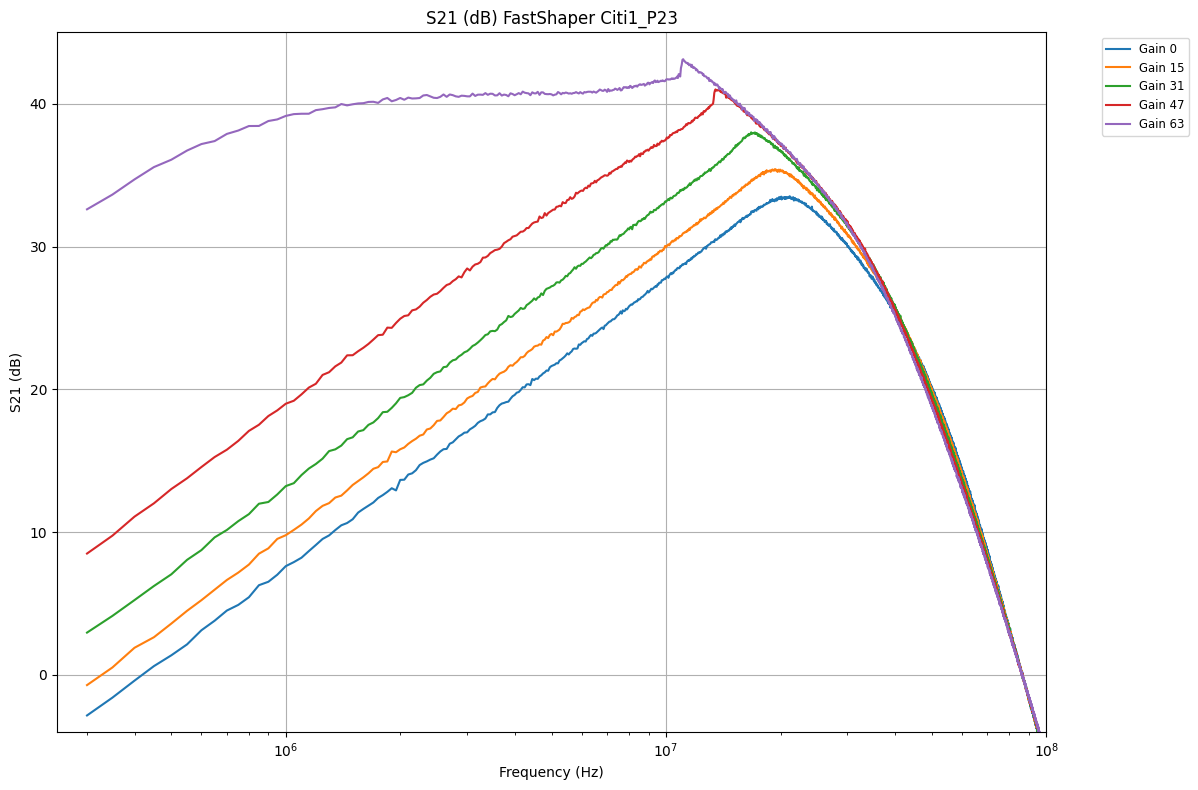

In [8]:
plt.figure(figsize=(12, 8))

# Gains available in the FastShaper dataset
fastshaper_gains = [0, 15, 31, 47, 63]

# Loop through the preloaded data for FastShaper
for i in fastshaper_gains:
    df_fastshaper = data['Citi1_P23_FastShaper'][i]  # Replace with the actual dataset key
    
    # Plot S21 (dB) vs Frequency (Hz)
    plt.plot(df_fastshaper['Frequency (Hz)'], df_fastshaper['S21 (dB)'], label=f'Gain {i}')

# Customize the plot
plt.xlabel('Frequency (Hz)')
plt.ylim(-4, 45)  # Adjust the range if necessary based on your FastShaper data
plt.xscale('log')
plt.ylabel('S21 (dB)')
plt.xlim(2.5e5, 1e8)
plt.title('S21 (dB) FastShaper Citi1_P23')  # Update title for clarity
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.grid()
plt.show()


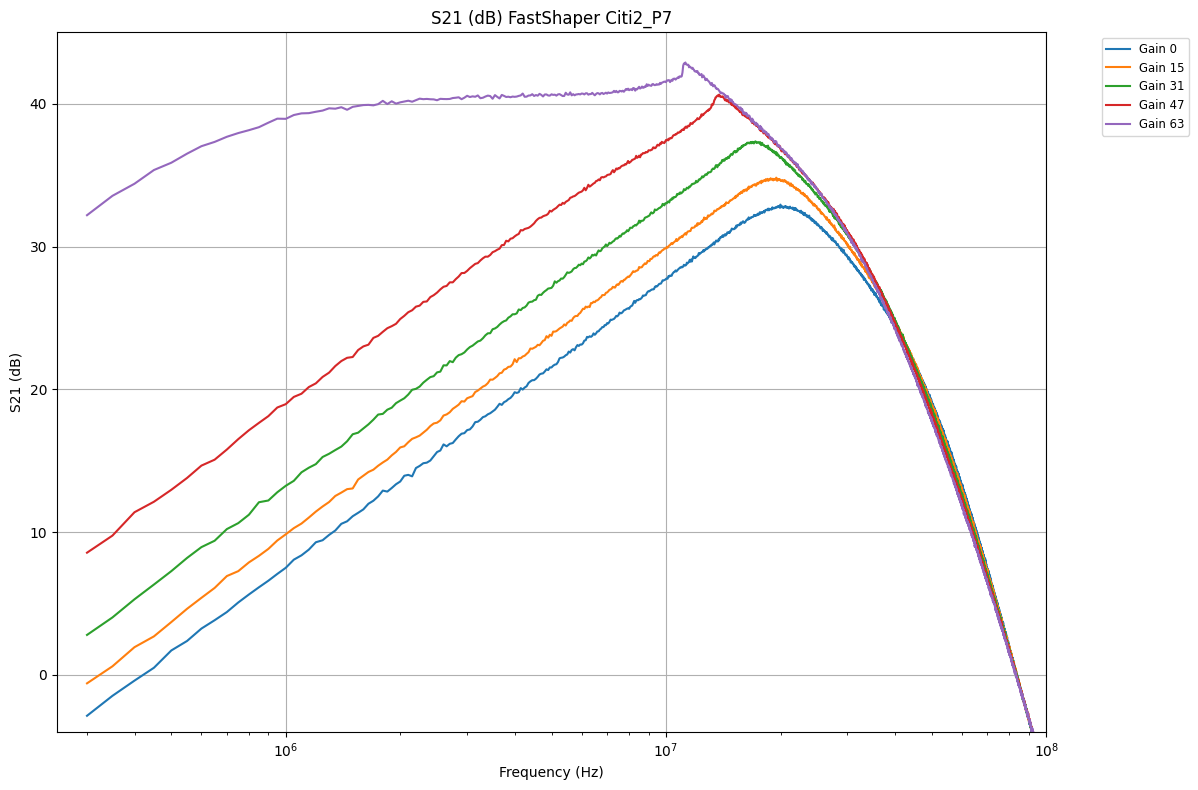

In [9]:
plt.figure(figsize=(12, 8))

# Gains available in the FastShaper dataset
fastshaper_gains = [0, 15, 31, 47, 63]

# Loop through the preloaded data for FastShaper
for i in fastshaper_gains:
    df_fastshaper = data['Citi2_P7_FastShaper'][i]  # Replace with the actual dataset key
    
    # Plot S21 (dB) vs Frequency (Hz)
    plt.plot(df_fastshaper['Frequency (Hz)'], df_fastshaper['S21 (dB)'], label=f'Gain {i}')

# Customize the plot
plt.xlabel('Frequency (Hz)')
plt.ylim(-4, 45)  # Adjust the range if necessary based on your FastShaper data
plt.xscale('log')
plt.ylabel('S21 (dB)')
plt.xlim(2.5e5, 1e8)
plt.title('S21 (dB) FastShaper Citi2_P7')  # Update title for clarity
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.grid()
plt.show()


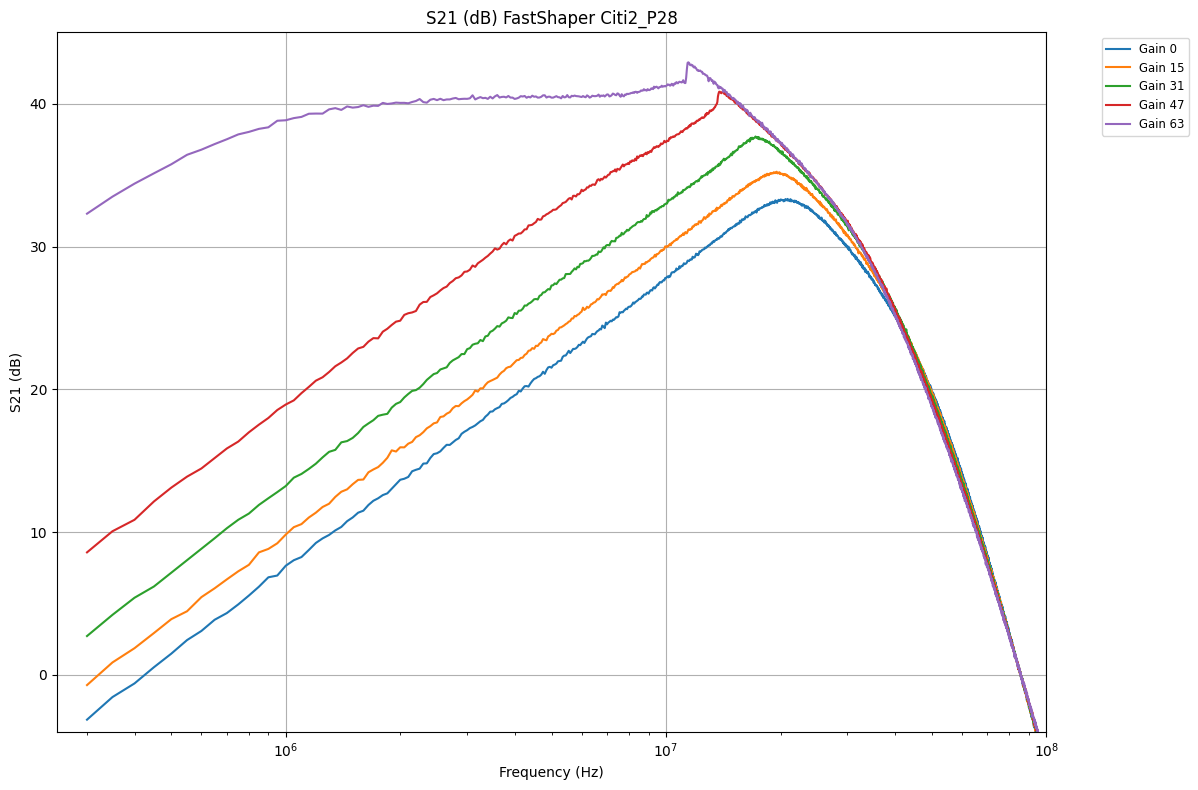

In [10]:
plt.figure(figsize=(12, 8))

# Gains available in the FastShaper dataset
fastshaper_gains = [0, 15, 31, 47, 63]

# Loop through the preloaded data for FastShaper
for i in fastshaper_gains:
    df_fastshaper = data['Citi2_P28_FastShaper'][i]  # Replace with the actual dataset key
    
    # Plot S21 (dB) vs Frequency (Hz)
    plt.plot(df_fastshaper['Frequency (Hz)'], df_fastshaper['S21 (dB)'], label=f'Gain {i}')

# Customize the plot
plt.xlabel('Frequency (Hz)')
plt.ylim(-4, 45)  # Adjust the range if necessary based on your FastShaper data
plt.xscale('log')
plt.ylabel('S21 (dB)')
plt.xlim(2.5e5, 1e8)
plt.title('S21 (dB) FastShaper Citi2_P28')  # Update title for clarity
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.grid()
plt.show()


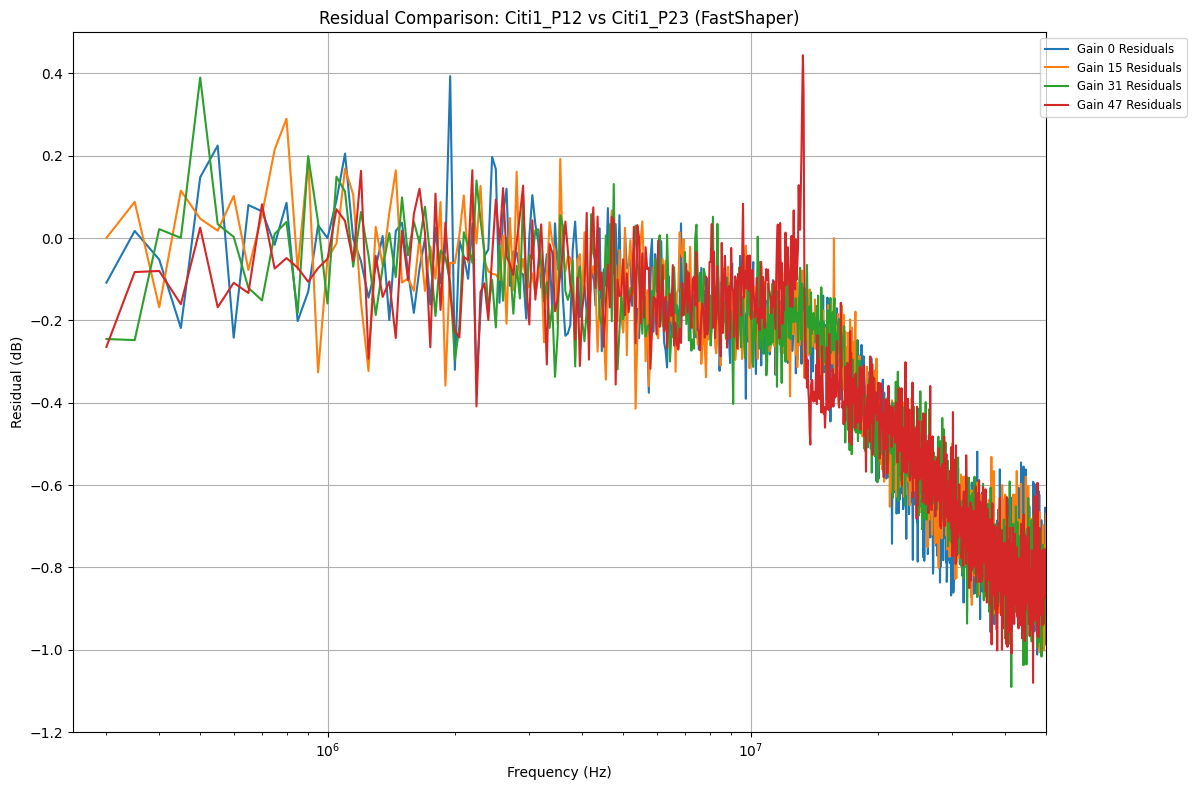

In [10]:
import matplotlib.pyplot as plt

# Load the datasets for FastShaper from Citi1
citi1_p12_fs = data["Citi1_P12_FastShaper"]
citi1_p23_fs = data["Citi1_P23_FastShaper"]

# Gains to compare
fastshaper_gains = [0, 15, 31, 47]

# Initialize the plot for residuals
plt.figure(figsize=(12, 8))

# Compare datasets from Citi1_P12_FastShaper and Citi1_P23_FastShaper
for gain in fastshaper_gains:
    # Extract data for the same gain
    p12_data = citi1_p12_fs[gain]
    p23_data = citi1_p23_fs[gain]
    
    # Compute residuals (difference in S21 (dB))
    residuals = p12_data['S21 (dB)'] - p23_data['S21 (dB)']
    
    # Plot residuals
    plt.plot(
        p12_data['Frequency (Hz)'], residuals, 
        label=f'Gain {gain} Residuals'
    )

# Customize the plot
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.xlim(2.5e5, 50e6)
plt.ylabel('Residual (dB)')
plt.ylim(-1.2,0.5)
plt.title('Residual Comparison: Citi1_P12 vs Citi1_P23 (FastShaper)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.savefig('residuos_fs.pdf', dpi=1000)
plt.show()


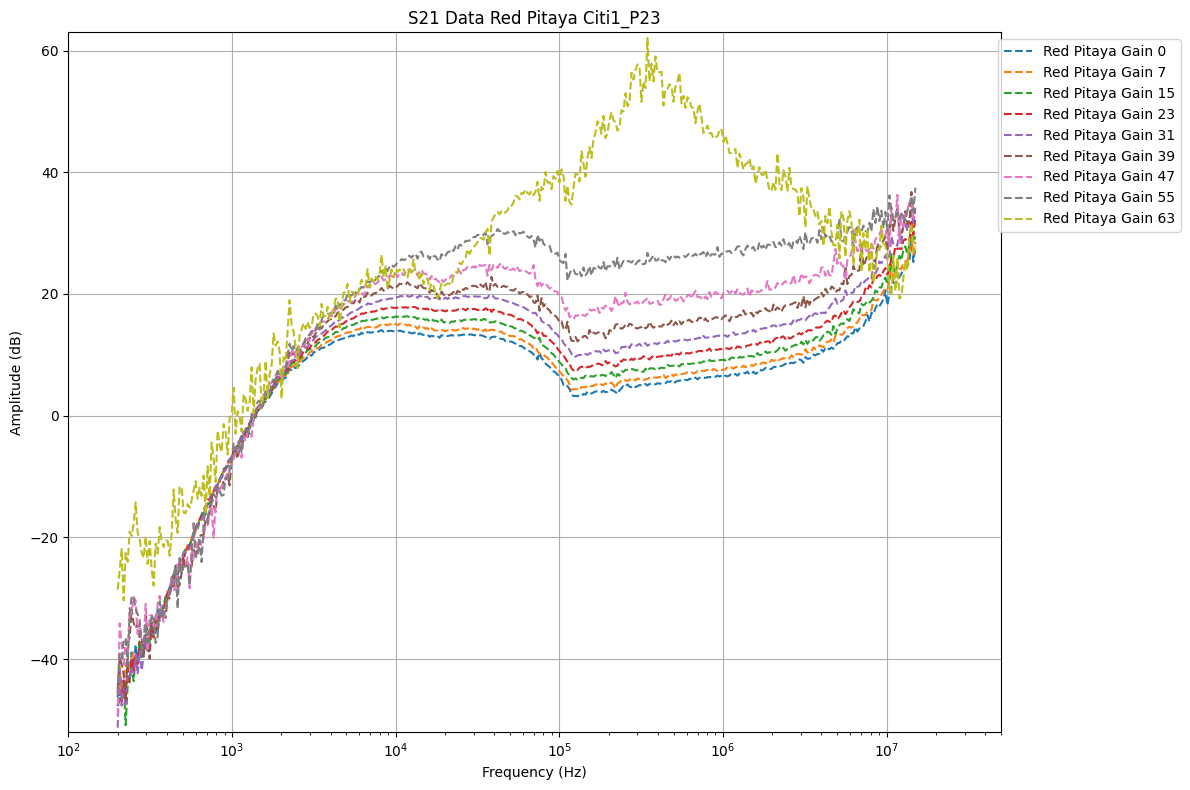

In [11]:
# Directories
red_pitaya_dir = '/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones Pitaya/3.12.2024/Citi1-P23-PreAmp'

# Gains to compare
gains = [0, 7, 15, 23, 31, 39, 47, 55, 63]

# Function to load Red Pitaya data
def load_red_pitaya_data(gain):
    filename = f"ganancia{gain}.csv"
    filepath = os.path.join(red_pitaya_dir, filename)
    return pd.read_csv(filepath)

# Comparison
plt.figure(figsize=(12, 8))
for gain in gains:
    # Load Red Pitaya data
    red_pitaya_data = load_red_pitaya_data(gain)

    # Strip column names to handle extra spaces
    red_pitaya_data.columns = red_pitaya_data.columns.str.strip()
    
    # Plot Red Pitaya data
    plt.plot(
        red_pitaya_data['Frequency [Hz]'], 
        red_pitaya_data['Amplitude [dB]']-28, 
        linestyle='--', label=f"Red Pitaya Gain {gain}"
    )

# Customize plot
plt.xlabel("Frequency (Hz)")
plt.xscale('log')
plt.xlim(1e2, 5e7)
plt.ylim(-52, 63)
plt.ylabel("Amplitude (dB)")
plt.title("S21 Data Red Pitaya Citi1_P23")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.savefig('datos_crudos_pitaya.pdf', dpi=1000)
plt.show()


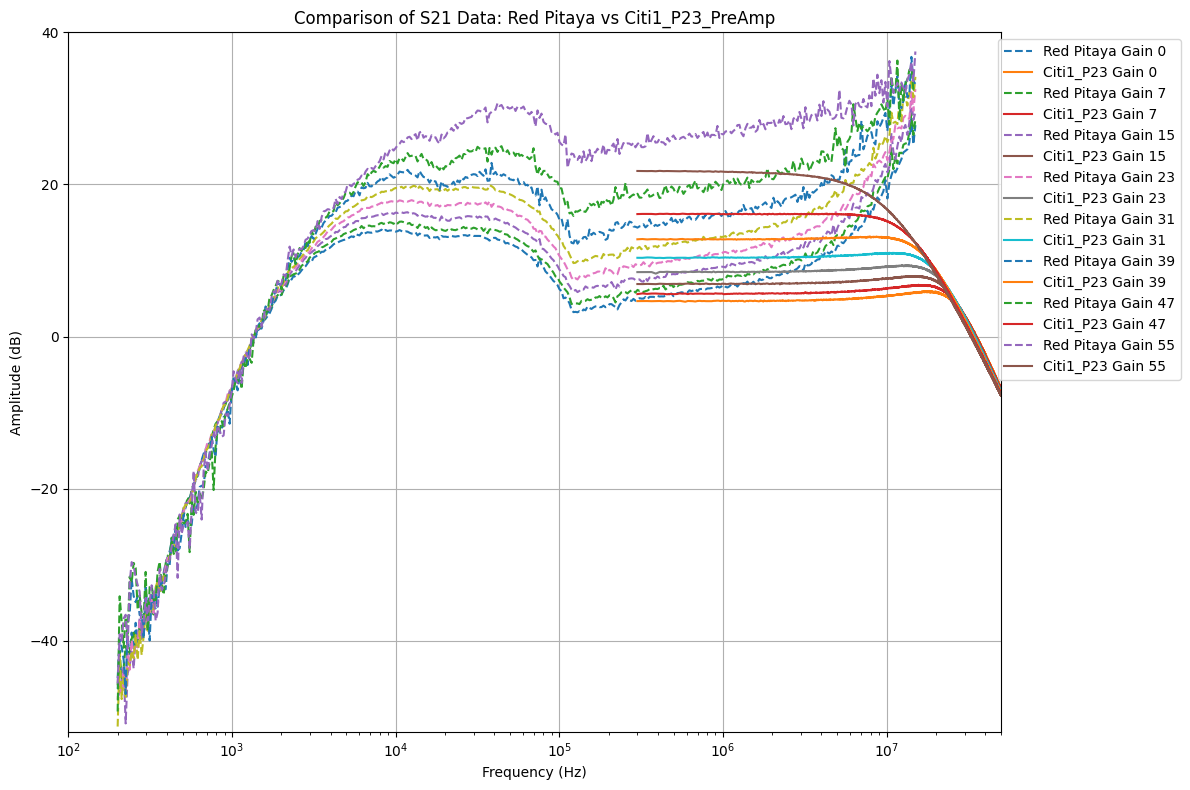

In [13]:
# Directories
red_pitaya_dir = '/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones Pitaya/3.12.2024/Citi1-P23-PreAmp'

# Gains to compare
gains = [0, 7, 15, 23, 31, 39, 47, 55]

# Function to load Red Pitaya data
def load_red_pitaya_data(gain):
    filename = f"ganancia{gain}.csv"
    filepath = os.path.join(red_pitaya_dir, filename)
    return pd.read_csv(filepath)

# Comparison
plt.figure(figsize=(12, 8))
for gain in gains:
    # Load Red Pitaya data
    red_pitaya_data = load_red_pitaya_data(gain)

    # Strip column names to handle extra spaces
    red_pitaya_data.columns = red_pitaya_data.columns.str.strip()
    
    # Plot Red Pitaya data
    plt.plot(
        red_pitaya_data['Frequency [Hz]'], 
        red_pitaya_data['Amplitude [dB]']-28, 
        linestyle='--', label=f"Red Pitaya Gain {gain}"
    )

    # Load Citi1_P23_PreAmp data (assuming `data` dict is preloaded)
    df_citi1_p23_preamp = data['Citi1_P23_PreAmp'][gain]
    
    # Plot VNA data
    plt.plot(df_citi1_p23_preamp['Frequency (Hz)'], df_citi1_p23_preamp['S21 (dB)'], label=f'Citi1_P23 Gain {gain}')

# Customize plot
plt.xlabel("Frequency (Hz)")
plt.xscale('log')
plt.xlim(1e2, 5e7)
plt.ylim(-52, 40)
plt.ylabel("Amplitude (dB)")
plt.title("Comparison of S21 Data: Red Pitaya vs Citi1_P23_PreAmp")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.grid()
plt.tight_layout()
plt.show()


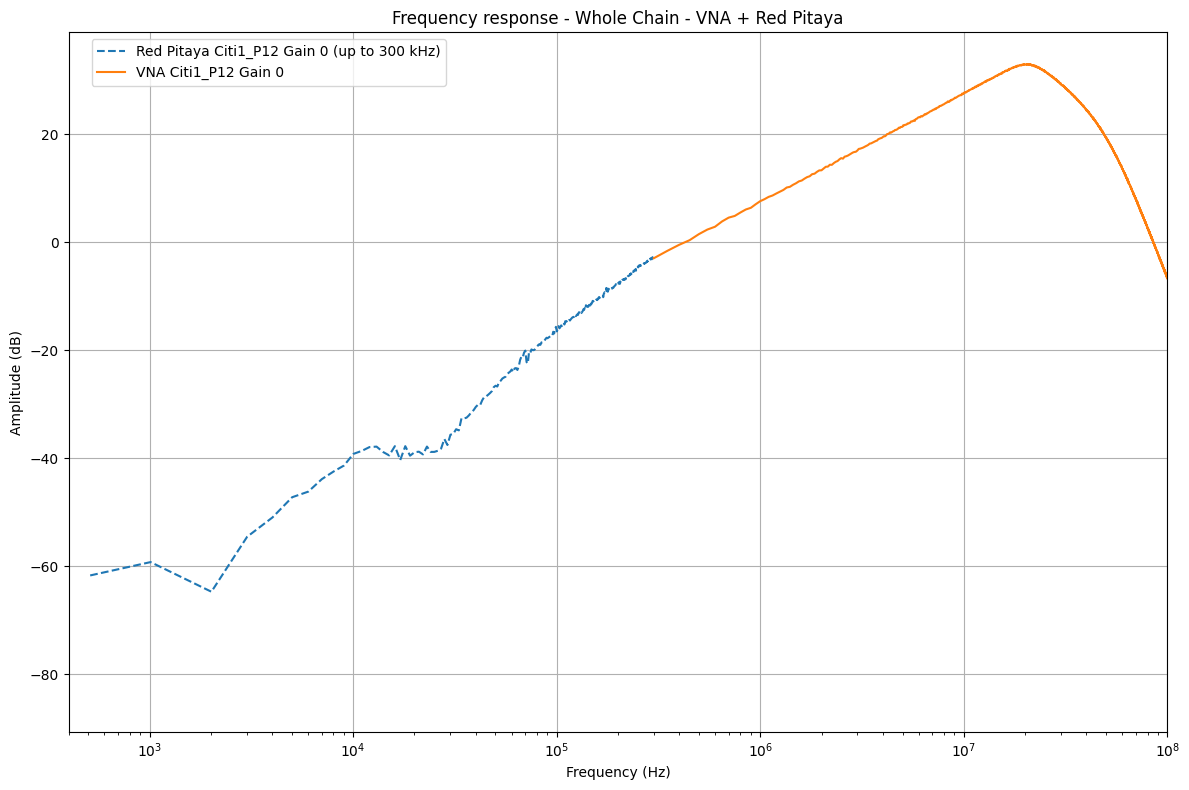

In [12]:
# Comparison
plt.figure(figsize=(12, 8))

fs = pd.read_csv(r'/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Mediciones/Mediciones Pitaya/29.11.2024/full_chain_gain0.csv')

# Strip column names to handle extra spaces
fs.columns = fs.columns.str.strip()

# Filter Red Pitaya data up to 300 kHz
fs_filtered = fs[fs['Frequency [Hz]'] <= 300e3]

# Plot filtered Red Pitaya data
plt.plot(
        fs_filtered['Frequency [Hz]'], 
        fs_filtered['Amplitude [dB]']-18.5, 
        linestyle='--', label=f"Red Pitaya Citi1_P12 Gain 0 (up to 300 kHz)"
)


# Load Citi1_P23_PreAmp data (assuming `data` dict is preloaded)
df_citi1_p12_fs = data['Citi1_P12_FastShaper'][0]
    
# Plot VNA data
plt.plot(df_citi1_p12_fs['Frequency (Hz)'], df_citi1_p12_fs['S21 (dB)'], label=f'VNA Citi1_P12 Gain 0')


# Customize plot
plt.xlabel("Frequency (Hz)")
plt.xscale('log')
plt.xlim(4e2, 1e8)
#plt.ylim(-48, 17)
plt.ylabel("Amplitude (dB)")
plt.title("Frequency response - Whole Chain - VNA + Red Pitaya")
plt.legend(loc="upper right", bbox_to_anchor=(0.35, 1))
plt.grid(True)
plt.tight_layout()
plt.savefig('cadena_completa_pitaya+vna.pdf', dpi=1000)
plt.show()


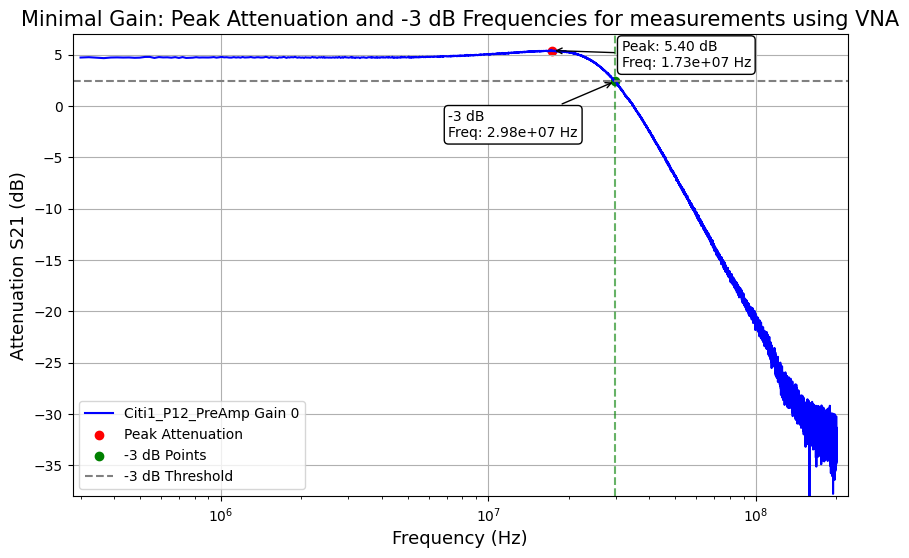

Peak Attenuation: 5.40 dB
-3 dB Frequencies: 29792310.26 Hz


In [35]:
# Select minimal gain for Citi1_P12_PreAmp
minimal_gain = 0
df_minimal_gain = data['Citi1_P12_PreAmp'][minimal_gain]

# Extract frequency and S21 (dB) data
frequencies = df_minimal_gain['Frequency (Hz)']
attenuations = df_minimal_gain['S21 (dB)']

# Calculate peak attenuation
peak_attenuation = max(attenuations)

# Find the -3 dB attenuation level
threshold = peak_attenuation - 3

# Identify frequencies where attenuation is closest to the threshold
below_threshold = attenuations >= threshold
indices = below_threshold[below_threshold].index

# Find the frequencies corresponding to -3 dB points
f_upper = frequencies.iloc[indices[-1]] if len(indices) > 0 else None

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(frequencies, attenuations, label="Citi1_P12_PreAmp Gain 0", color="blue")

# Highlight the peak
plt.scatter([frequencies[attenuations.idxmax()]], [peak_attenuation], color="red", label="Peak Attenuation")
plt.annotate(
    f"Peak: {peak_attenuation:.2f} dB\nFreq: {frequencies[attenuations.idxmax()]:.2e} Hz",
    xy=(frequencies[attenuations.idxmax()], peak_attenuation),
    xytext=(50, -12),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

# Highlight -3 dB points
if f_upper:
    plt.scatter([f_upper], [threshold], color="green", label="-3 dB Points")
    plt.axvline(f_upper, color="green", linestyle="--", alpha=0.6)
    plt.annotate(
        f"-3 dB\nFreq: {f_upper:.2e} Hz",
        xy=(f_upper, threshold),
        xytext=(-120, -40),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

# Customize plot
plt.title("Minimal Gain: Peak Attenuation and -3 dB Frequencies for measurements using VNA", fontsize=15)
plt.xlabel('Frequency (Hz)', fontsize=13)
plt.ylabel('Attenuation S21 (dB)', fontsize=13)
plt.ylim(-38, 7)
plt.xlim(2.8e5, 2.2e8)
plt.xscale('log')
plt.axhline(threshold, color="gray", linestyle="--", label="-3 dB Threshold")
plt.legend()
plt.grid(True)
plt.savefig('analisis_vna_preamp.pdf', dpi=1000)
plt.show()

# Output the results
print(f"Peak Attenuation: {peak_attenuation:.2f} dB")
if f_upper:
    print(f"-3 dB Frequencies: {f_upper:.2f} Hz")
else:
    print("Could not determine -3 dB frequencies.")


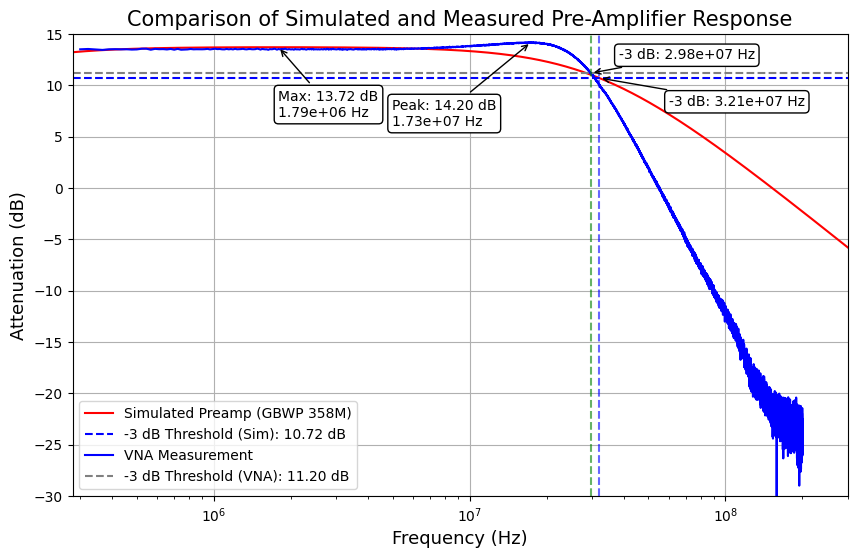

In [62]:
# Load and prepare simulated preamp data
df_sim = pd.read_csv('/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Etapa Final de Proyecto/preamp_v2.txt', sep="\t", skiprows=1, names=['Frequency', 'V(out_preamp)'], encoding='ISO-8859-1')
df_sim['Attenuation'] = df_sim['V(out_preamp)'].apply(lambda x: float(x.split(',')[0][1:].replace('dB', '').strip()))

# Find simulated max attenuation and -3 dB points
max_attenuation_sim = df_sim['Attenuation'].max()
freq_max_attenuation_sim = df_sim['Frequency'][df_sim['Attenuation'].idxmax()]
target_attenuation_sim = max_attenuation_sim - 3
df_sim['Diff'] = np.abs(df_sim['Attenuation'] - target_attenuation_sim)
df_sorted_sim = df_sim.sort_values(by='Diff')
left_3db_freq_sim = df_sorted_sim[df_sorted_sim['Frequency'] < freq_max_attenuation_sim].iloc[0]['Frequency']
right_3db_freq_sim = df_sorted_sim[df_sorted_sim['Frequency'] > freq_max_attenuation_sim].iloc[0]['Frequency']

# Load and prepare VNA data
minimal_gain = 0
df_vna = data['Citi1_P12_PreAmp'][minimal_gain]
frequencies_vna = df_vna['Frequency (Hz)']
attenuations_vna = df_vna['S21 (dB)']

# Find VNA peak attenuation and -3 dB points
peak_attenuation_vna = max(attenuations_vna)
threshold_vna = peak_attenuation_vna - 3
below_threshold_vna = attenuations_vna >= threshold_vna
indices_vna = below_threshold_vna[below_threshold_vna].index
f_upper_vna = frequencies_vna.iloc[indices_vna[-1]] if len(indices_vna) > 0 else None

# Plot the data
plt.figure(figsize=(10, 6))

# Simulated data
plt.plot(df_sim['Frequency'], df_sim['Attenuation'], color='red', label='Simulated Preamp (GBWP 358M)')
plt.axhline(y=target_attenuation_sim, color='blue', linestyle='--', label=f'-3 dB Threshold (Sim): {target_attenuation_sim:.2f} dB')
plt.axvline(left_3db_freq_sim, color='blue', linestyle='--', alpha=0.6)
plt.axvline(right_3db_freq_sim, color='blue', linestyle='--', alpha=0.6)

# Annotate simulated data
plt.annotate(
    f'Max: {max_attenuation_sim:.2f} dB\n{freq_max_attenuation_sim:.2e} Hz',
    xy=(freq_max_attenuation_sim, max_attenuation_sim),
    xytext=(0, -50),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

plt.annotate(
    f'-3 dB: {right_3db_freq_sim:.2e} Hz',
    xy=(right_3db_freq_sim, target_attenuation_sim),
    xytext=(50, -20),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

# VNA data
plt.plot(frequencies_vna, attenuations_vna + 8.8, label='VNA Measurement', color='blue')
plt.axhline(y=threshold_vna + 8.8, color='gray', linestyle='--', label=f'-3 dB Threshold (VNA): {threshold_vna + 8.8:.2f} dB')
plt.axvline(f_upper_vna, color='green', linestyle='--', alpha=0.6)

# Annotate VNA data
plt.annotate(
    f'Peak: {peak_attenuation_vna + 8.8:.2f} dB\n{frequencies_vna[attenuations_vna.idxmax()]:.2e} Hz',
    xy=(frequencies_vna[attenuations_vna.idxmax()], peak_attenuation_vna + 8.8),
    xytext=(-100, -60),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)
if f_upper_vna:
    plt.annotate(
        f'-3 dB: {f_upper_vna:.2e} Hz',
        xy=(f_upper_vna, threshold_vna + 8.8),
        xytext=(20, 10),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

# Ensure all annotations are within plot bounds
plt.ylim(-30, 15)
plt.xlim(2.8e5, 3e8)
plt.xscale('log')

# Customize plot
plt.title('Comparison of Simulated and Measured Pre-Amplifier Response', fontsize=15)
plt.xlabel('Frequency (Hz)', fontsize=13)
plt.ylabel('Attenuation (dB)', fontsize=13)
plt.grid(True)
plt.legend(loc='lower left')

# Show the plot
plt.savefig('comparacion_vna_sim_preamp.pdf', dpi=1000)
plt.show()



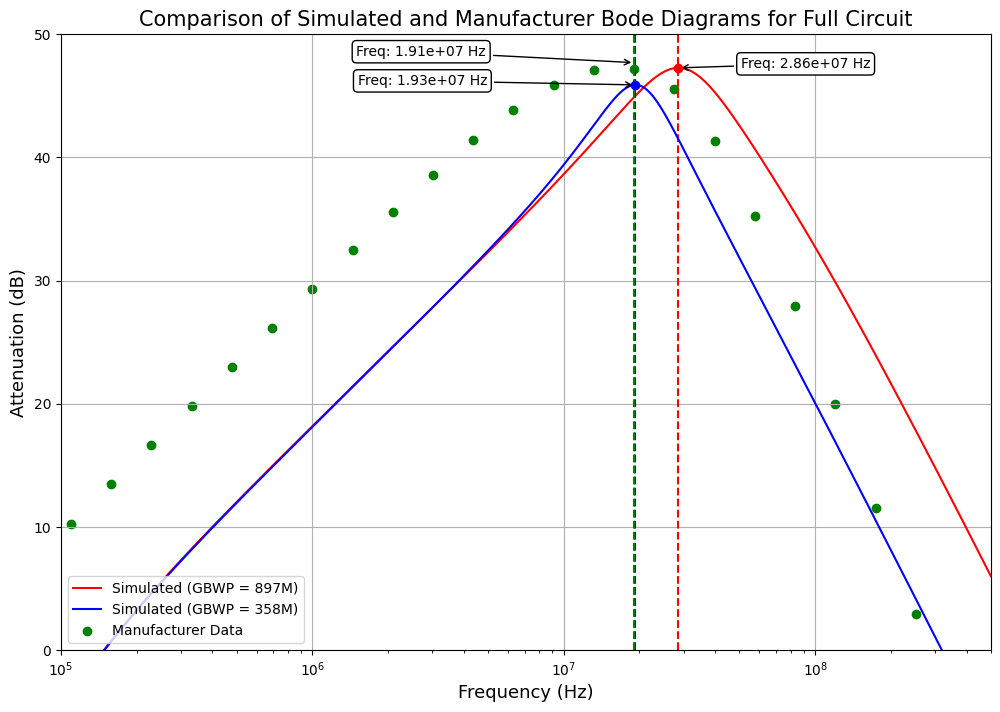

In [64]:
# Load the first data file (Version 1.5)
df_v15 = pd.read_csv(
    '/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Etapa Final de Proyecto/bode_circuito_completo_con_capacitores_en_preamp_inversor_v1,5.txt',
    sep="\t", skiprows=1, names=['Frequency', 'V(out)'], encoding='ISO-8859-1'
)
df_v15['Attenuation'] = df_v15['V(out)'].apply(lambda x: float(x.split(',')[0][1:].replace('dB', '').strip())) + 6.5

# Find the peak attenuation for Version 1.5
max_v15_idx = df_v15['Attenuation'].idxmax()
max_v15_freq = df_v15['Frequency'].iloc[max_v15_idx]
max_v15_value = df_v15['Attenuation'].iloc[max_v15_idx]

# Load the second data file (Version 2.0)
df_v2 = pd.read_csv(
    '/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Etapa Final de Proyecto/bode_circuito_completo_con_capacitores_en_preamp_inversor_v2.txt',
    sep="\t", skiprows=1, names=['Frequency', 'V(out)'], encoding='ISO-8859-1'
)
df_v2['Attenuation'] = df_v2['V(out)'].apply(lambda x: float(x.split(',')[0][1:].replace('dB', '').strip())) + 6.5

# Find the peak attenuation for Version 2.0
max_v2_idx = df_v2['Attenuation'].idxmax()
max_v2_freq = df_v2['Frequency'].iloc[max_v2_idx]
max_v2_value = df_v2['Attenuation'].iloc[max_v2_idx]

# Load manufacturer data
df_manufacturer = pd.read_csv(
    '/home/lautaro/GitHub/Laboratorio_6_7_ITeDA/Bode-Manufacturer + Código/mag_fschain.csv', 
    names=("frec", "atenuation")
)
df_manufacturer = df_manufacturer.tail(-1).astype('float')  # Remove header and ensure numeric type

# Find the peak attenuation for manufacturer data (manual adjustment to pick previous point)
max_manufacturer_idx = df_manufacturer['atenuation'].idxmax() - 1  # Move to the previous point
max_manufacturer_freq = df_manufacturer['frec'].iloc[max_manufacturer_idx]
max_manufacturer_value = df_manufacturer['atenuation'].iloc[max_manufacturer_idx]

# Create a larger figure
plt.figure(figsize=(12, 8))  # Set width and height in inches

# Plotting the Version 1.5 data
plt.plot(df_v15['Frequency'], df_v15['Attenuation'], color='red', label='Simulated (GBWP = 897M)')
plt.scatter(max_v15_freq, max_v15_value, color='red', zorder=5)
plt.axvline(x=max_v15_freq, color='red', linestyle='--')
plt.annotate(f'Freq: {max_v15_freq:.2e} Hz', 
             xy=(max_v15_freq, max_v15_value), 
             xytext=(45, 0),  # Adjusting to the left side
             textcoords='offset points', 
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='black', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Plotting the Version 2.0 data
plt.plot(df_v2['Frequency'], df_v2['Attenuation'], color='blue', label='Simulated (GBWP = 358M)')
plt.scatter(max_v2_freq, max_v2_value, color='blue', zorder=5)
plt.axvline(x=max_v2_freq, color='blue', linestyle='--')
plt.annotate(f'Freq: {max_v2_freq:.2e} Hz', 
             xy=(max_v2_freq, max_v2_value), 
             xytext=(-200, 0), 
             textcoords='offset points', 
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='black', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Plotting the manufacturer data
plt.scatter(df_manufacturer['frec'], df_manufacturer['atenuation']-5.5, color='green', label='Manufacturer Data')
plt.axvline(x=max_manufacturer_freq, color='green', linestyle='--')
plt.annotate(f'Freq: {max_manufacturer_freq:.2e} Hz', 
             xy=(max_manufacturer_freq, max_manufacturer_value-5),  # Adjust y position for clarity
             xytext=(-200, 5),  # Adjust the offset to prevent overlap
             textcoords='offset points', 
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='black', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Set titles and labels
plt.title('Comparison of Simulated and Manufacturer Bode Diagrams for Full Circuit', fontsize=15)
plt.xlabel('Frequency (Hz)', fontsize=13)
plt.ylabel('Attenuation (dB)', fontsize=13)
plt.legend(loc='lower left')  # Add a legend in the lower-left corner
plt.xscale('log')  # Set x-axis to log scale
plt.xlim(1e5, 5e8)  # Adjust the x-axis limits
plt.ylim(0, 50)  # Adjust the y-axis limits
plt.grid(True)  # Add grid

# Save and display the plot
plt.savefig('bode_diagram_comparison_with_manufacturer.pdf', dpi=1000)
plt.show()


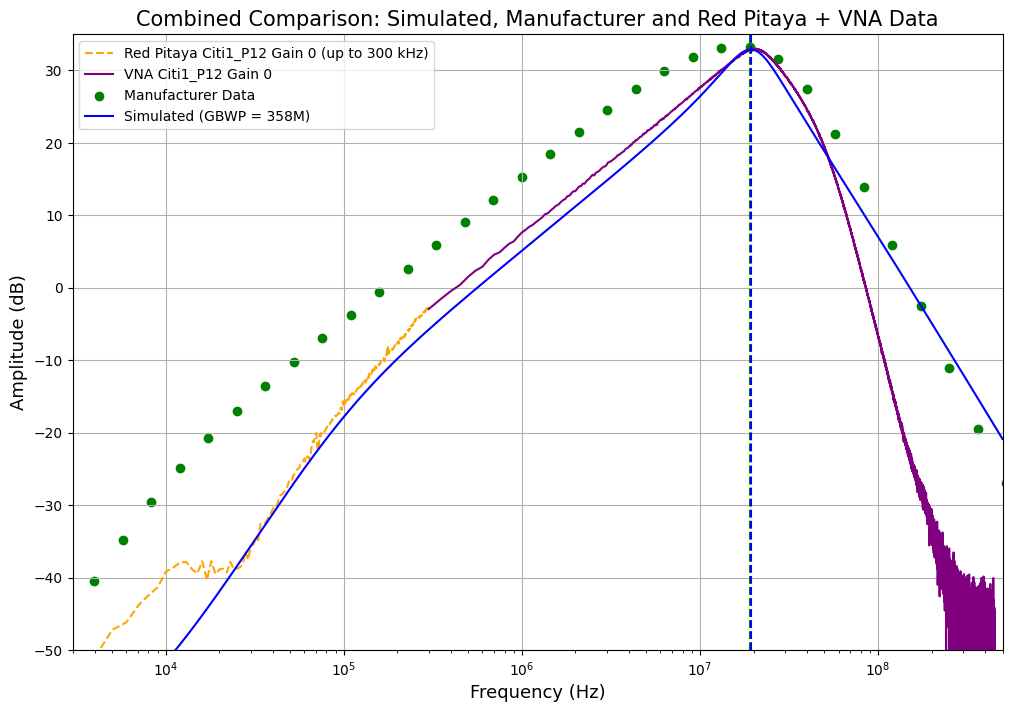

In [80]:
# Create a larger figure
plt.figure(figsize=(12, 8))  # Set width and height in inches

# Plotting the Red Pitaya data
plt.plot(
    fs_filtered['Frequency [Hz]'],
    fs_filtered['Amplitude [dB]'] - 18.5,
    linestyle='--',
    label="Red Pitaya Citi1_P12 Gain 0 (up to 300 kHz)",
    color='orange'
)

# Plotting the VNA data
plt.plot(
    df_citi1_p12_fs['Frequency (Hz)'],
    df_citi1_p12_fs['S21 (dB)'],
    label="VNA Citi1_P12 Gain 0",
    color='purple'
)

# Plotting the Manufacturer Data
plt.scatter(
    df_manufacturer['frec'],
    df_manufacturer['atenuation'] - 19.5,
    color='green',
    label='Manufacturer Data'
)
plt.axvline(
    x=max_manufacturer_freq,
    color='green',
    linestyle='--'
)
plt.annotate(
    f'Freq: {max_manufacturer_freq:.2e} Hz',
    xy=(max_manufacturer_freq, max_manufacturer_value - 5.5),
    xytext=(-200, 5),  # Adjust the offset to prevent overlap
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10,
    color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

# Plotting the Version 2.0 data (GBWP = 358M)
plt.plot(
    df_v2['Frequency'],
    df_v2['Attenuation']-13,
    color='blue',
    label='Simulated (GBWP = 358M)'
)
plt.scatter(
    max_v2_freq,
    max_v2_value,
    color='blue',
    zorder=5
)
plt.axvline(
    x=max_v2_freq,
    color='blue',
    linestyle='--'
)
plt.annotate(
    f'Freq: {max_v2_freq:.2e} Hz',
    xy=(max_v2_freq, max_v2_value),
    xytext=(-200, 0),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10,
    color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

# Set titles and labels
plt.title('Combined Comparison: Simulated, Manufacturer and Red Pitaya + VNA Data', fontsize=15)
plt.xlabel('Frequency (Hz)', fontsize=13)
plt.ylabel('Amplitude (dB)', fontsize=13)
plt.legend(loc='upper left')  # Add a legend in the lower-left corner
plt.xscale('log')  # Set x-axis to log scale
plt.xlim(3e3, 5e8)  # Adjust the x-axis limits to encompass all data
plt.ylim(-50, 35)  # Adjust the y-axis limits for full data visibility
plt.grid(True)  # Add grid

# Save and display the plot
plt.savefig('combined_comparison_plot.pdf', dpi=1000)
plt.show()
